# Homework 1 - Supervised Deep Learning

##  Classification task

In [20]:
#importing libraries
import csv
import pandas as pd
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform # Distribution for gridsearch
from sklearn.model_selection import KFold
from skorch.callbacks import EarlyStopping
from skorch import NeuralNetRegressor
import torch
from tqdm import tqdm           # Loop track bar
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms 

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


from skorch import NeuralNetClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from skorch.utils import to_device
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EarlyStopping

import seaborn as sb 
sb.set_style( "darkgrid")

In [3]:
# Setting the seed or random_state for reproducibility
np.random.seed(123456)
torch.manual_seed(123456)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


### Dataset

The dataset consider is the MNIST dataset

In [4]:
mnist = fetch_openml('mnist_784', cache=True)

In [ ]:
X = mnist.data.astype('float32').values
y = mnist.target.astype('int64').values
X = X.reshape(-1, 1, 28, 28)
X, y = shuffle(X, y)

In [6]:
#train test split -- default test size =0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

#normalize
X_train /= 255
X_test /= 255

In [7]:
#printing shapes of the train and test
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((52500, 1, 28, 28), (52500,), (17500, 1, 28, 28), (17500,))

(-0.5, 27.5, 27.5, -0.5)

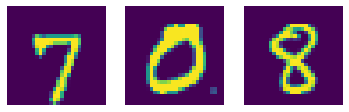

In [8]:
#Plot some digits
digit = X[0]
digit_pixels = digit.reshape(28, 28)
plt.subplot(131)
plt.imshow(digit_pixels)
plt.axis('off')
digit = X[1]
digit_pixels = digit.reshape(28, 28)
plt.subplot(132)
plt.imshow(digit_pixels)
plt.axis('off')
digit = X[2]
digit_pixels = digit.reshape(28, 28)
plt.subplot(133)
plt.imshow(digit_pixels)
plt.axis('off')

### Convolutional Network

In [10]:
class ConvNet(nn.Module):
    def __init__(self,dropout_rate=0.4,dropout_rate2=0.2,linear_1=50,Nh1=16,Nh2=32):
        
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=Nh1, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=Nh1, out_channels=Nh2, kernel_size=5, stride=1, padding=2)
        
        self.drop1=nn.Dropout2d(p=dropout_rate)  
        #fully connected layer
        self.fc1 = nn.Linear(Nh2 * 7 * 7, linear_1)
        self.drop2=nn.Dropout2d(p=dropout_rate2)
        self.fc2 = nn.Linear(linear_1, 10)

    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        
        x = self.drop2(x)
        x = self.fc2(x)
        
        return x

In [11]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

#early stopping
my_early = EarlyStopping(
    monitor='valid_loss',
    patience=3,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True)

#define network for grid search
net = NeuralNetClassifier(
    module=ConvNet,
    module__Nh1=16,
    module__Nh2=32,
    max_epochs=10,    
    iterator_train__num_workers=4,
    iterator_valid__num_workers=4,
    lr=1e-3,
    device=device,
    optimizer = optim.Adam,
    optimizer__lr=0.001,
    optimizer__weight_decay=1e-5, #L2 norm
    criterion=nn.CrossEntropyLoss,
    callbacks = [my_early])

In [ ]:
net.fit(X_train, y=y_train)

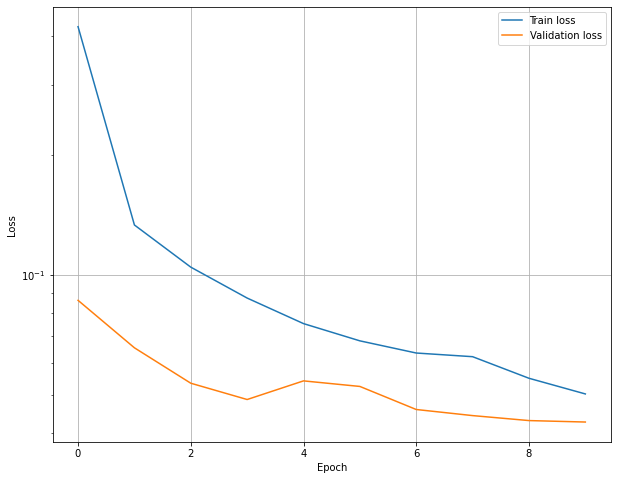

In [ ]:
val_loss=[]
train_loss=[]
for i in range(10):
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])
    
plt.figure(figsize=(10,8))
plt.semilogy(train_loss, label='Train loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()   

### Hyper Parameter search

In [13]:
#Define hyper parameters search
params = {
    'module__Nh1': [8, 16, 32, 64],
    'module__Nh2': [8, 16, 32, 64],
    "module__dropout_rate" : [0.01, 0.1, 0.5],
    "module__dropout_rate2" : [0.01, 0.1, 0.5],
    'optimizer': [optim.SGD, optim.Adam],
    'max_epochs': [200],
    'optimizer__lr':[ 0.001, 0.0001, 0.00001],
    'optimizer__weight_decay':[1e-4, 1e-3, 1e-2] }


In [14]:
gs = GridSearchCV(net, params, refit=True, cv=3, scoring="neg_mean_squared_error",verbose=10)

In [ ]:
gs.fit(X_train, y_train)


In [16]:
print(gs.best_score_, gs.best_params_)

-0.21076190476190473 {'max_epochs': 200, 'module__Nh1': 16, 'module__Nh2': 64, 'module__dropout_rate': 0.5, 'module__dropout_rate2': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0001}


In [21]:
#setting best estimator
net=gs.best_estimator_

### Plotting train and validation losses

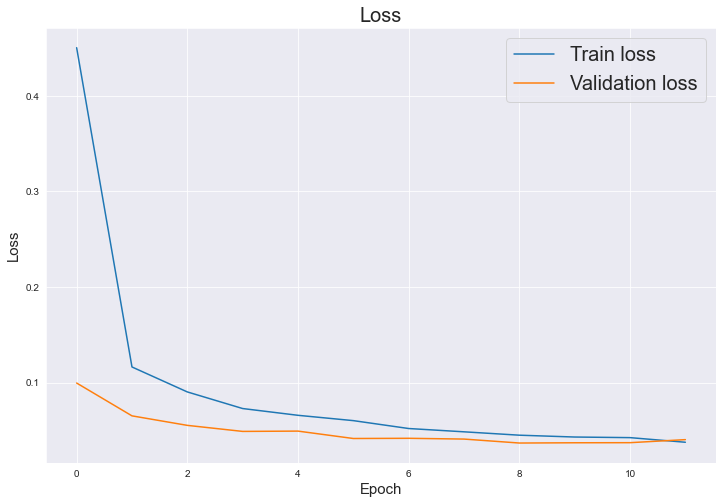

In [22]:
# get train losses from all epochs, a list of floats
history = net.history
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)

plt.legend(['Train loss', 'Validation loss'], loc='best', fontsize = 20)
plt.savefig("regularization_Losses.png")
plt.show()

In [23]:
#getting losses 

y_pred = net.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]

print("Train Loss:\t",round(train_loss,3))
print("Val Loss:\t",round(val_loss,3))
print("Test Loss:\t", 1-test_acc)

Train Loss:	 0.038
Val Loss:	 0.04
Test Loss:	 0.012114285714285744


## Confusion matrix

In [24]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

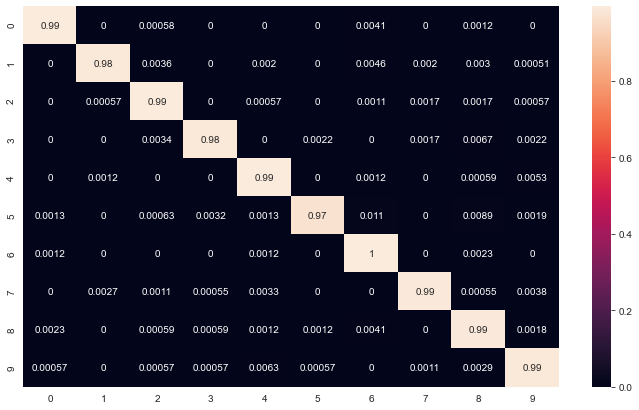

In [26]:
classes = ('0', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')

# Build confusion matrix
df_cm = pd.DataFrame(cf_matrix/ cf_matrix.sum(axis=1)[:, np.newaxis], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

## Network Analysis

### Weight histogram

In [27]:
#Access network parameters
my_best_net = net.module_

# Conv 1 layer
c1_w = my_best_net.conv1.weight.data.cpu().numpy()
c1_b = my_best_net.conv1.bias.data.cpu().numpy()

# Conv 2 layer
c2_w = my_best_net.conv2.weight.data.cpu().numpy()
c2_b = my_best_net.conv2.bias.data.cpu().numpy()

#First hidden Layer
h1_w = my_best_net.fc1.weight.data.cpu().numpy()
h1_b = my_best_net.fc1.bias.data.cpu().numpy()

#Second hidden Layer
h2_w = my_best_net.fc2.weight.data.cpu().numpy()
h2_b = my_best_net.fc2.bias.data.cpu().numpy()

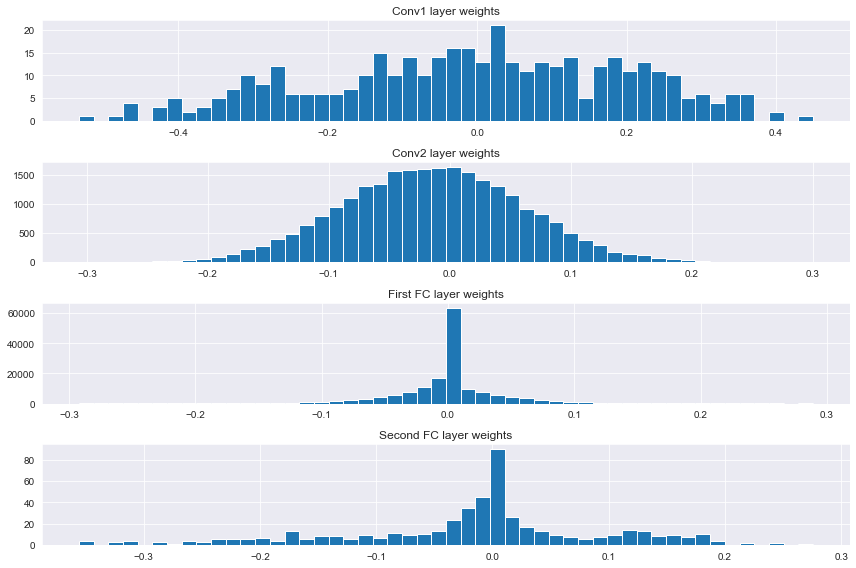

In [29]:
# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('Conv1 layer weights')
axs[1].hist(c2_w.flatten(), 50)
axs[1].set_title('Conv2 layer weights')
axs[2].hist(h1_w.flatten(), 50)
axs[2].set_title('First FC layer weights')
axs[3].hist(h2_w.flatten(), 50)
axs[3].set_title('Second FC layer weights')


plt.tight_layout()
plt.show()

### Activation Profile

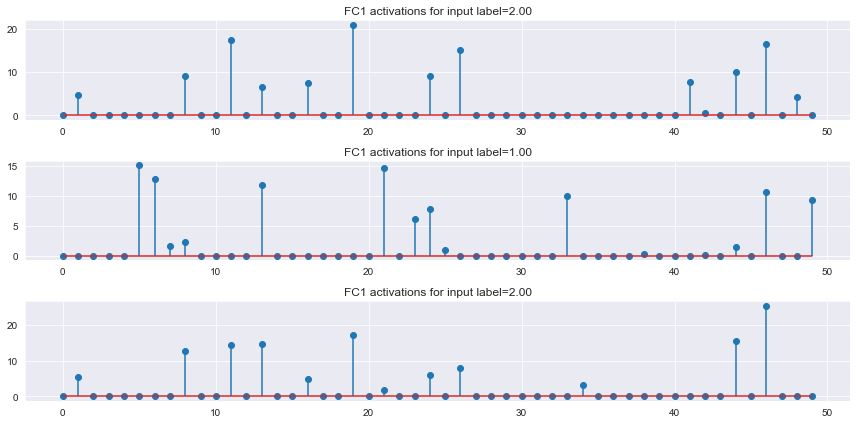

In [30]:
def get_activation(layer, input, output):
    global activation
    #activation = torch.softmax(output)
    activation = torch.relu(output)
    
### Register hook
net=my_best_net
hook_handle = net.fc1.register_forward_hook(get_activation)


### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor(X_train[0]).unsqueeze(0).to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor(X_train[1]).unsqueeze(0).to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor(X_train[2]).unsqueeze(0).to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('FC1 activations for input label=%.2f' % y_train[0])
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('FC1 activations for input label=%.2f' % y_train[1])
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('FC1 activations for input label=%.2f' % y_train[2])
plt.tight_layout()
plt.show()

## Receptive

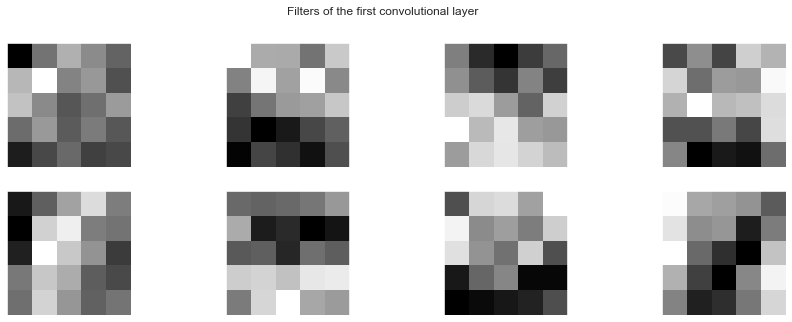

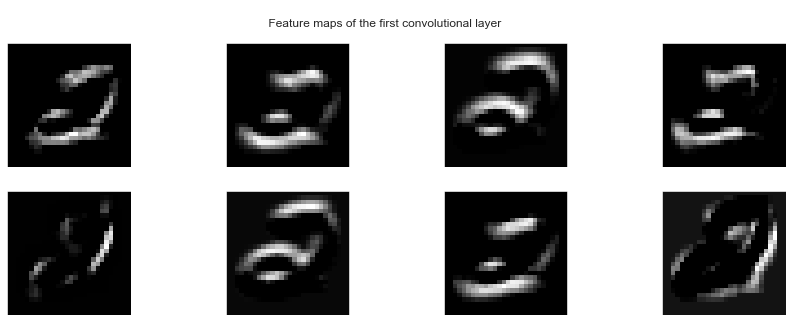

In [31]:
#first we collect the filters of the first convolutional layer 
filters_1 = my_best_net.conv1.weight
filters_1 = torch.squeeze(filters_1,1)

filters_1  = filters_1.cpu().detach().numpy()

features = []
input = torch.tensor(X_train[0]).unsqueeze(0).to(device)

#define a funcion that return the squeezed output of the called layer
def get_features_map(self, input, output):
    features.append(output.squeeze(0))

#used the method register_forward_hook to get the features maps
hook_handle = my_best_net.conv1.register_forward_hook(get_features_map)
my_best_net.eval()
with torch.no_grad():
    out = my_best_net(input)
    
### Remove hook
hook_handle.remove()

#plot the filters and their relative feature maps for the first sample of the test_dataset
plt.figure(figsize=(15,5))
for i in range(1, 9):
    plt.subplot(2,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(filters_1[i-1], cmap='gray')
plt.suptitle('Filters of the first convolutional layer') 

act = nn.ReLU()

plt.figure(figsize=(15,5))
for i in range(1, 9):
    plt.subplot(2,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(act(features[0][i-1]).cpu().detach().numpy(), cmap='gray')
plt.suptitle('\n Feature maps of the first convolutional layer')
plt.show()

Text(0.5, 0.98, 'Filters of first convolutional layer')

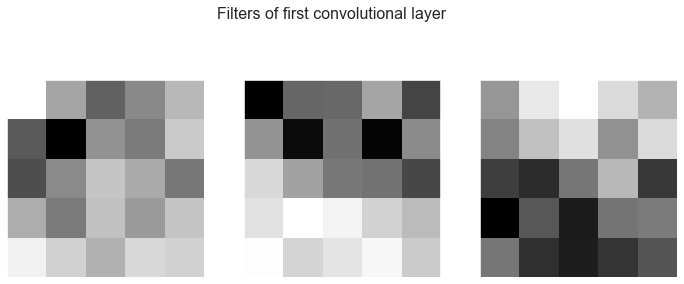

In [32]:
weights_CV1 = net.conv1.weight.data.cpu().numpy()
weights_CV2 = net.conv2.weight.data.cpu().numpy()

fig, ax = plt.subplots(1,3, figsize=(12, 5))
ax = ax.flatten()
for i in range(3):
    ax[i].imshow( weights_CV1[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Filters of first convolutional layer', fontsize=16)

Text(0.5, 0.98, 'Filters of second convolutional layer')

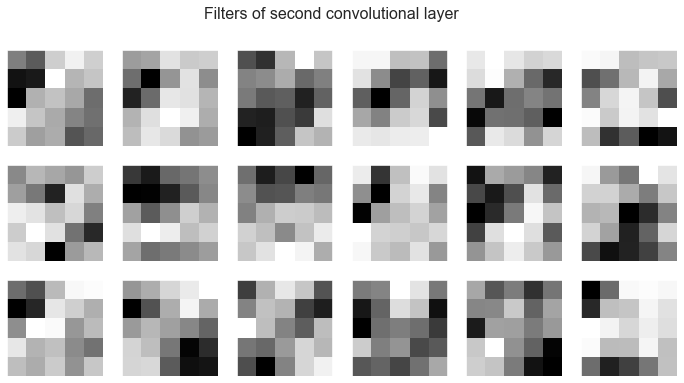

In [33]:
fig, ax = plt.subplots(3,6, figsize=(12, 6))
ax = ax.flatten()
for i in range(6):
    for j in range(3):
        ax[i*3+j].imshow( weights_CV2[i, j, :,:], cmap='Greys')
        ax[i*3+j].set_xticks([])
        ax[i*3+j].set_yticks([])
        
fig.suptitle('Filters of second convolutional layer', fontsize=16)

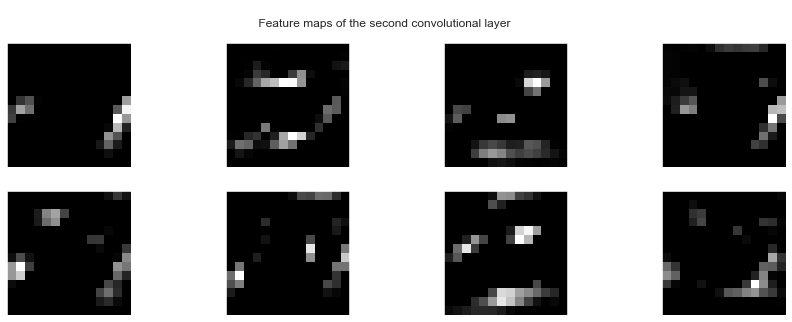

In [43]:
#first we collect the filters of the first convolutional layer 
filters_1 = my_best_net.conv2.weight
filters_1 = torch.squeeze(filters_1,1)

filters_1  = filters_1.cpu().detach().numpy()

features = []
input = torch.tensor(X_train[0]).unsqueeze(0).to(device)

#define a funcion that return the squeezed output of the called layer
def get_features_map(self, input, output):
    features.append(output.squeeze(0))

#used the method register_forward_hook to get the features maps
hook_handle = my_best_net.conv2.register_forward_hook(get_features_map)
my_best_net.eval()
with torch.no_grad():
    out = my_best_net(input)
### Remove hook
hook_handle.remove()
act = nn.ReLU()
plt.figure(figsize=(15,5))
for i in range(1, 9):
    plt.subplot(2,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(act(features[0][i-1]).cpu().detach().numpy(), cmap='gray')
plt.suptitle('\n Feature maps of the second convolutional layer')
plt.show()